In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from models import SimpleModel, ConcreteModel, ConcreteDropout, normal_nll

torch.manual_seed(2809)
np.random.seed(2809)
torch.cuda.manual_seed(2809)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def print_weights(model):
    print(model.fc1.weight.data)
    print(model.fc2.weight.data)
    print(model.fc1.bias.data)
    print(model.fc2.bias.data)

def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)
    
def evaluate_loss(pred, true, log_var=None):
    if log_var is None:
        criterion = nn.MSELoss()
        return criterion(pred, true)
    else:
        return normal_nll(pred, true, log_var)

In [10]:
def generate_data(N, X_dim, Y_dim):
    """
    Function to generate data
    """
    sigma = 0.7  # ground truth
    X = torch.randn(N, X_dim)
    w = torch.ones((X_dim, Y_dim))*2.0
    b = 8.0
    Y = torch.mm(X, w) + b + sigma*torch.randn(N, Y_dim)
    return X, Y

In [11]:
checkpoint_path = 'checkpoint.pth'
batch_size = 25
n_hidden = 3
n_train = 1000
n_val = 100
n_data = n_train + n_val
X_dim = 4
Y_dim = 2
epoch = 0
# For ConcreteModel
l = 1e-4 # length scale
wr = l**2. / n_train
dr = 2. / n_train

#model = SimpleModel(X_dim, n_hidden, Y_dim)
model = ConcreteModel(X_dim, n_hidden, Y_dim, wr, dr)
model_resume = SimpleModel(X_dim, n_hidden, Y_dim)
model_resume = ConcreteModel(X_dim, n_hidden, Y_dim, wr, dr)

optimizer = optim.Adam(model.parameters(), 
                      betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
optimizer_resume = optim.Adam(model_resume.parameters(), 
                             betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

In [12]:
X, Y = generate_data(n_data, X_dim, Y_dim)
X_train, Y_train = X[:n_train], Y[:n_train]
X_val, Y_val = X[n_train:], Y[n_train:]

In [14]:
# Train for one epoch
losses = []
while epoch < 200:
    optimizer.zero_grad()
    pred, log_var, reg = model(X_train)
    loss = evaluate_loss(pred, Y_train, log_var)
    loss.backward()
    optimizer.step()
    loss_val = loss.item()
    losses.append(loss_val)
    epoch += 1

save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            }, checkpoint_path)
#print_weights(model)
#optimizer.state_dict()

In [15]:
# Resume training


print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
epoch = checkpoint['epoch']
model_resume.load_state_dict(checkpoint['state_dict'])
optimizer_resume.load_state_dict(checkpoint['optimizer'])
#print_weights(model_resume)
#optimizer_resume.state_dict()

=> loading checkpoint 'checkpoint.pth'


In [16]:
# Train model for 100 more epochs
while epoch < 300:
    optimizer_resume.zero_grad()
    pred, log_var, reg = model_resume(X_train)
    loss = evaluate_loss(pred, Y_train, log_var)
    loss.backward()
    optimizer_resume.step()
    loss_val = loss.item()
    losses.append(loss_val)
    epoch += 1

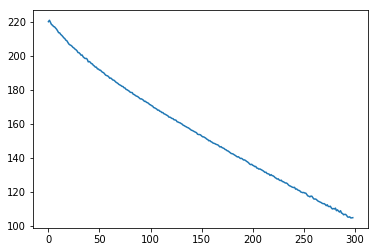

In [17]:
losses_arr = np.array(losses)
plt.plot(losses)